In [16]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits

In [17]:
image = fits.open('image3.fits')[0].data

In [18]:
image.shape

(100, 100)

In [ ]:
def ct_fft(x):
    N = x.shape[0]
    if len(x) <= 1: return x
    
    even = ct_fft(x[0::2])
    odd = ct_fft(x[1::2])
    
    w_odd = np.exp(-2j*np.pi*np.arange(N)/N)[:N // 2] * odd
    res = np.zeros(N, dtype=complex)
    
    for k in range(N//2):
        res[k] = even[k] + w_odd[k]
        res[k + N // 2] = even[k] - w_odd[k]
    
    return res

def ct_ifft(x):
    N = len(x)
    x_conj = np.conj(x)
    y = ct_fft(x_conj)
    return np.conj(y) / N

def fft_bluestein(x):
    N = len(x)
    n = np.arange(N)
    tl = 1 << (2*N - 1).bit_length()
    W = np.exp(-1j * np.pi * n**2 / N)
    
    a = x * W
    
    b = np.zeros(tl, dtype=complex)
    b[:N] = W**-1
    b[-(N - 1):] = np.exp(1j * np.pi * n[1:][::-1]**2 / N)
    
    apad = np.zeros(tl, dtype=complex)
    apad[:N] = a
    
    cal = ct_fft(apad) * ct_fft(b)
    res_arr = ct_ifft(cal)
    
    return res_arr[:N] * W

def fft(x):
    x_dim = x.ndim
    if x_dim == 1:
        l = len(x)
        if l % 2 == 0: return ct_fft(x)
        else: return fft_bluestein(x)
        
    else:
        for _ in range(x_dim):
            x = np.apply_along_axis(fft_bluestein, axis=_,arr=x)
        return x

In [20]:
img3_fft = fft(image)
img3_fft_lib = np.fft.fft2(image)

In [105]:
print(img3_fft.real[0][0] / np.mean(img3_fft.real))
print(np.mean(img3_fft.imag))

167288.66666663365
-5.980837158858776e-13


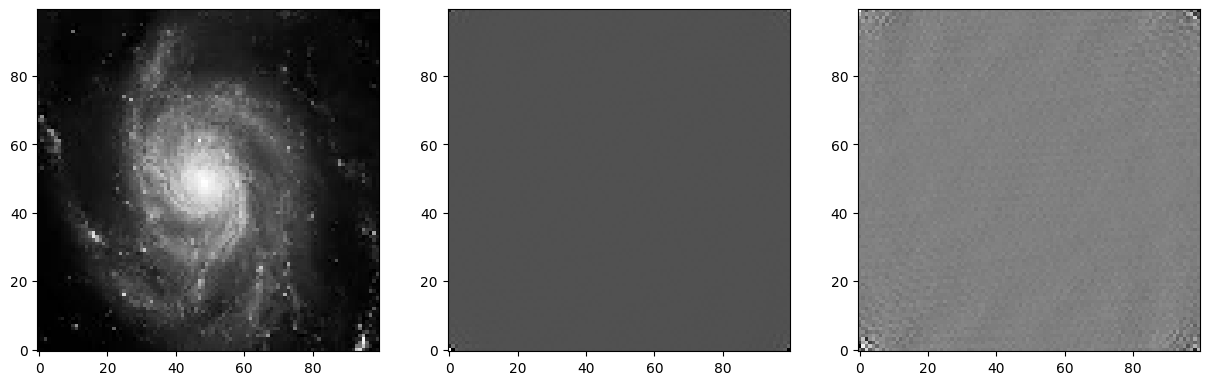

In [38]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray', origin='lower')
plt.subplot(1, 3, 2)
plt.imshow(img3_fft.real, cmap='gray', origin='lower')
plt.subplot(1, 3, 3)
plt.imshow(img3_fft.imag, cmap='gray', origin='lower')

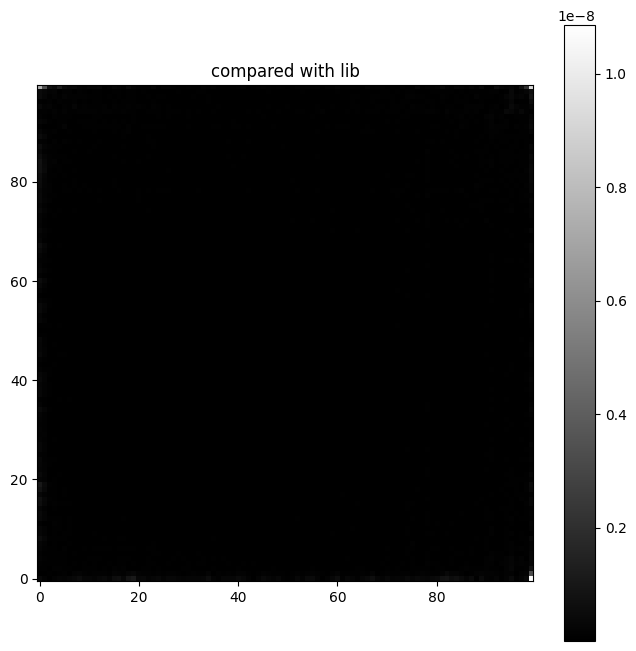

(maximum)gaps between two fft: 1.0857086974034162e-08


In [48]:
diff_lib = np.abs(img3_fft - img3_fft_lib)
plt.figure(figsize=(8, 8))
plt.imshow(diff_lib, cmap='gray', origin='lower')
plt.title("compared with lib")
plt.colorbar()
plt.show()
print("(maximum)gaps between two fft: "+str(np.max(diff_lib)))

In [22]:
ft_shift = np.fft.fftshift(img3_fft)

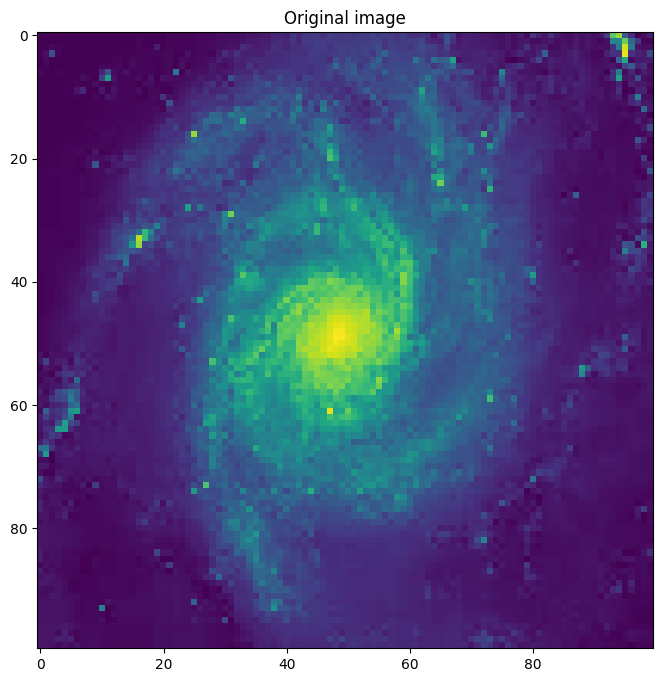

In [90]:
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title("Original image")
plt.show()

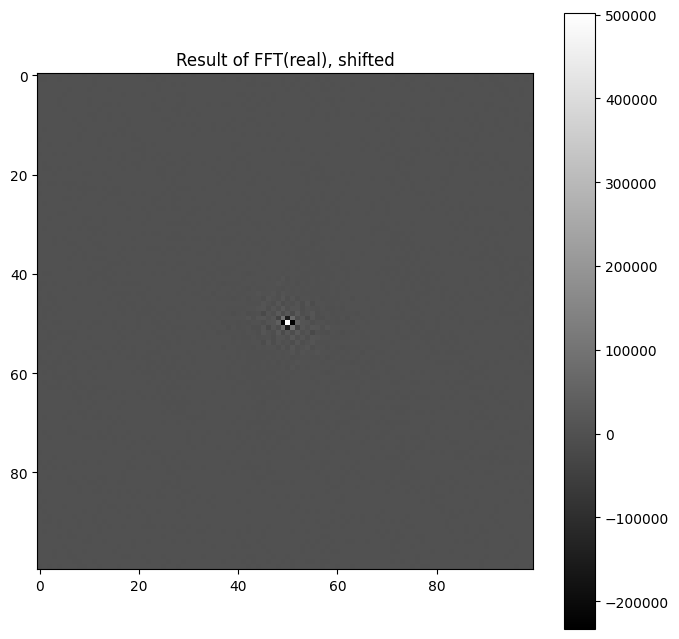

In [106]:
plt.figure(figsize=(8, 8))
plt.imshow(np.fft.fftshift(img3_fft.real), cmap="gray")
plt.title("Result of FFT(real), shifted")
plt.colorbar()
plt.show()

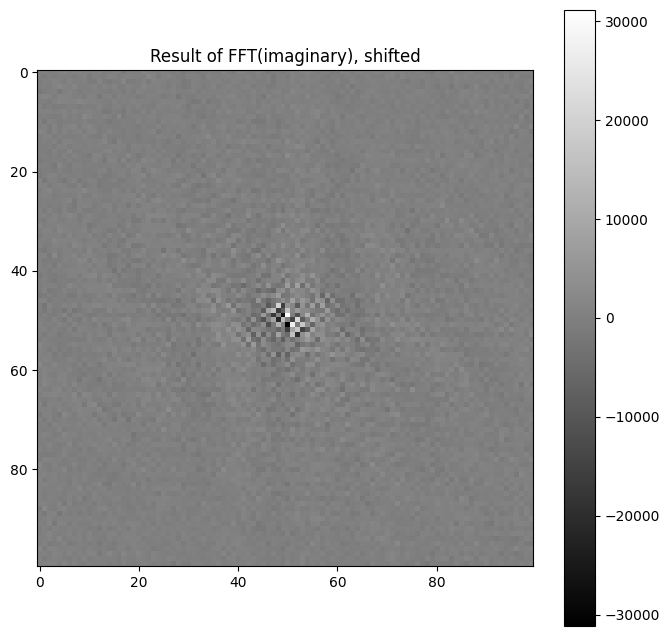

In [107]:
plt.figure(figsize=(8, 8))
plt.imshow(np.fft.fftshift(img3_fft.imag), cmap="gray")
plt.title("Result of FFT(imaginary), shifted")
plt.colorbar()
plt.show()

In [24]:
def get_freq(x):
    iy, ix = x.shape
    dx = np.fft.fftfreq(ix)
    dy = np.fft.fftfreq(iy)
    X, Y = np.meshgrid(dx, dy)
    return np.sqrt(X**2 + Y**2)

In [25]:
img3_freq = get_freq(img3_fft)
img3_freq_lib = get_freq(img3_fft_lib)
img3_freq_shifted = get_freq(ft_shift)

<function matplotlib.pyplot.show(close=None, block=None)>

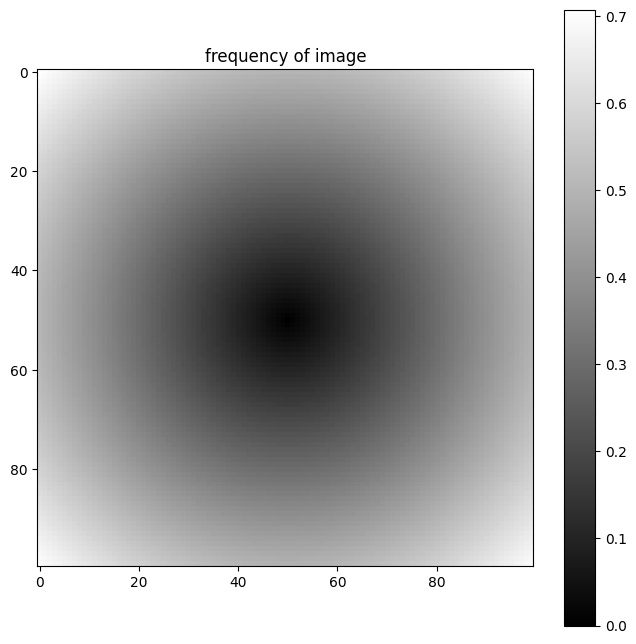

In [108]:
plt.figure(figsize=(8, 8))
plt.imshow(np.fft.fftshift(img3_freq), cmap='gray')
plt.colorbar()
plt.title("frequency of image")
plt.show

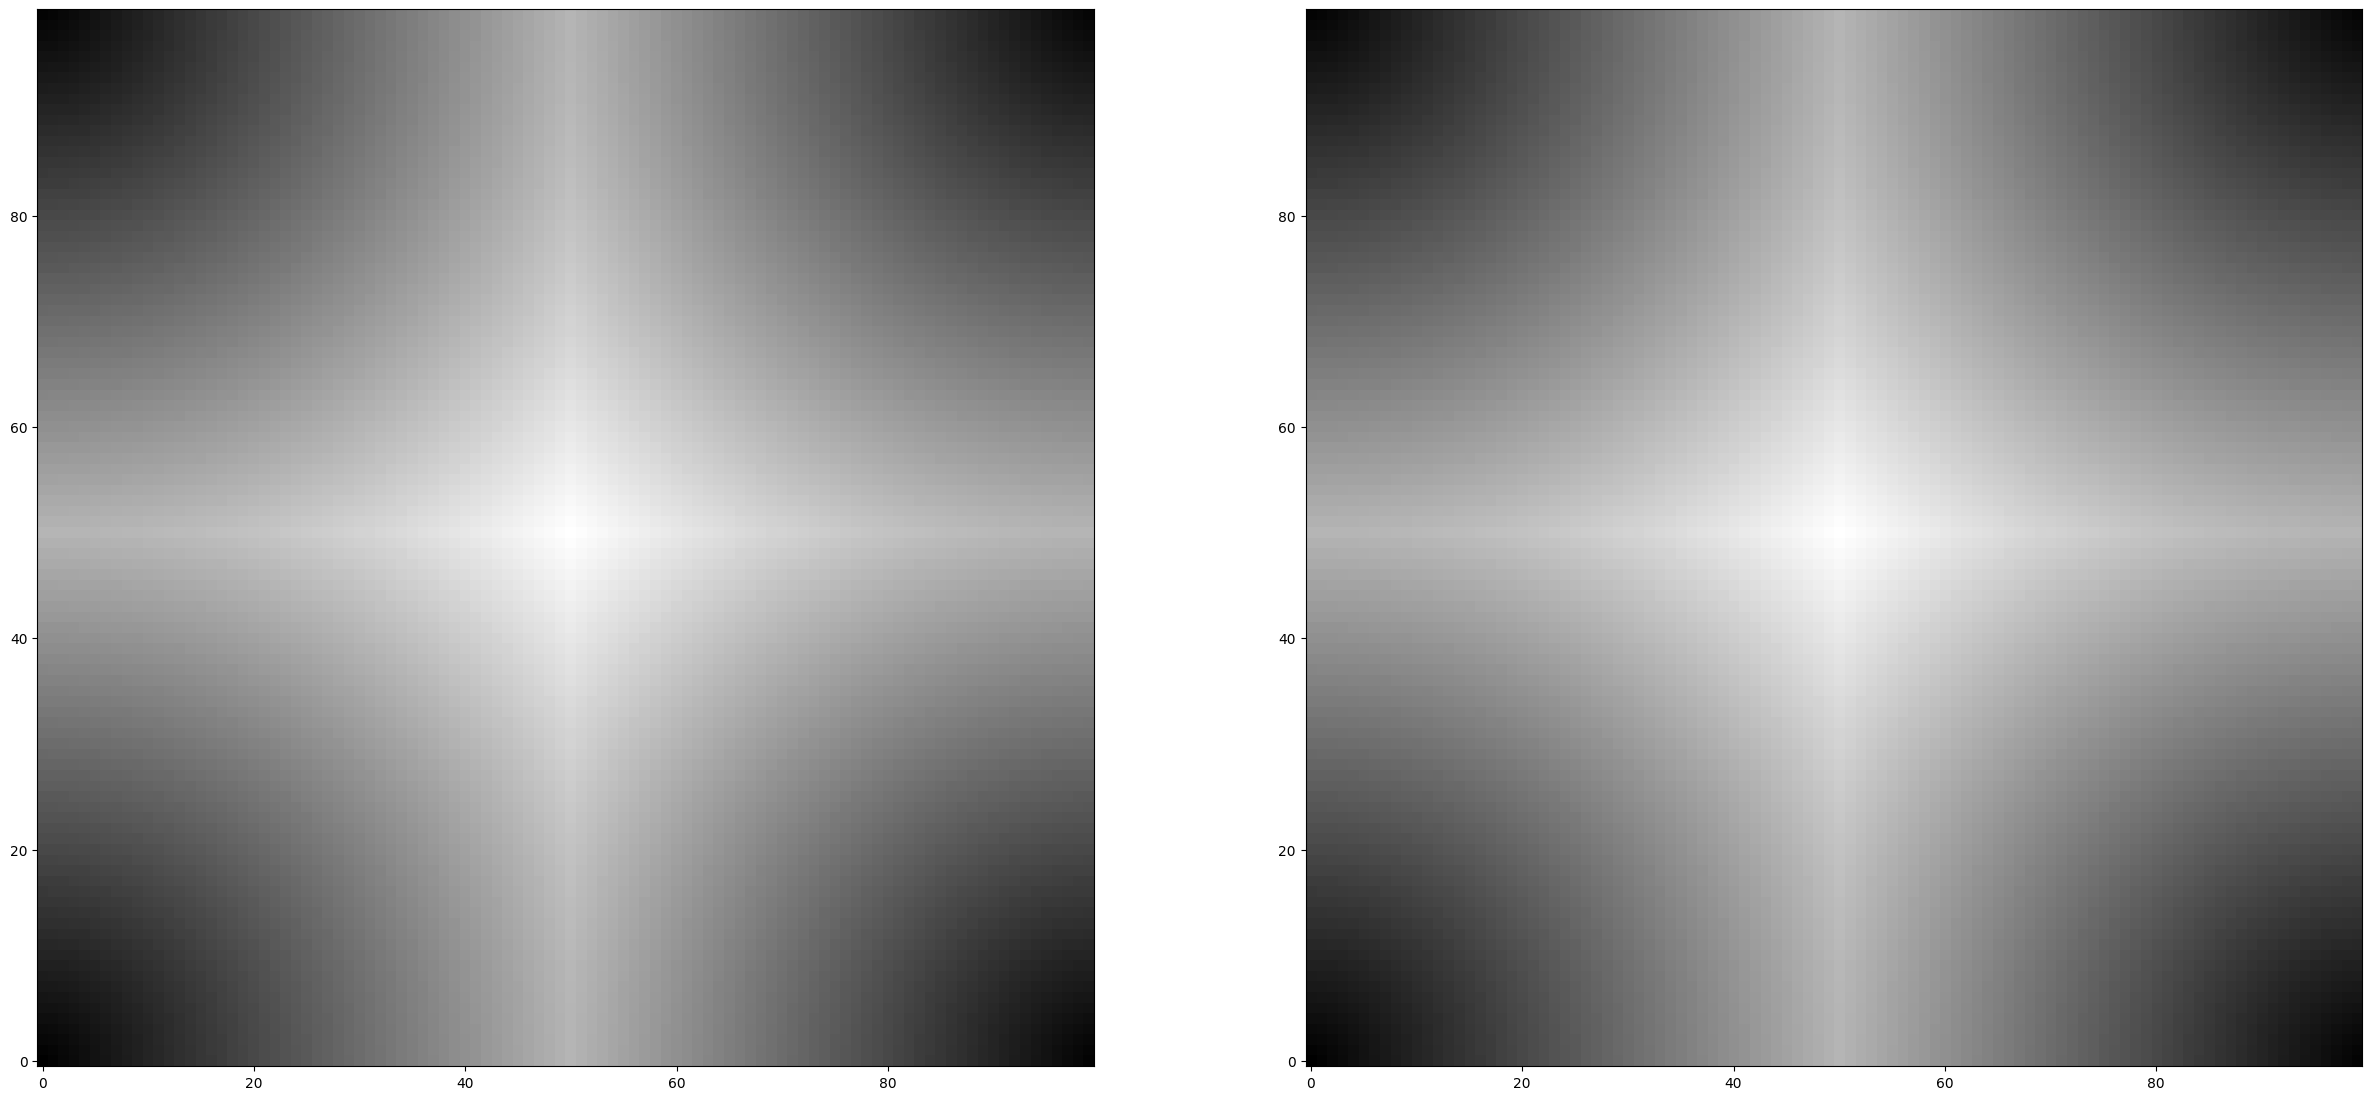

In [26]:
plt.figure(figsize=(30, 30), )
plt.subplot(1, 2, 1)
plt.imshow(img3_freq_lib, cmap='gray', origin='lower')
plt.subplot(1, 2, 2)
plt.imshow(img3_freq, cmap='gray', origin='lower')

In [27]:
img3_power = np.abs(img3_fft)**2
pow_freq = np.zeros((2, len(img3_freq.flatten())))
pow_freq[0] = img3_freq.flatten()
pow_freq[1] = img3_power.flatten()
sort_idx = np.argsort(pow_freq[0])
pow_freq = pow_freq[:, sort_idx]

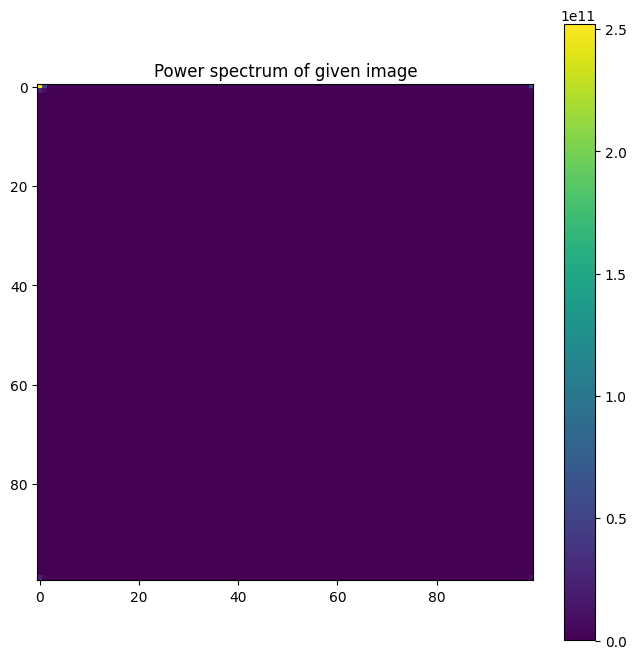

251869481956.0
# of Dominant Power: 10000


In [83]:
plt.figure(figsize=(8, 8))
plt.imshow(img3_power)
plt.colorbar()
plt.title("Power spectrum of given image")
plt.show()

max_pow = np.max(img3_power.flatten())
min_pow_cfreq = max_pow
for _ in range(len(pow_freq[0])):
    if pow_freq[0][_] > 1/5:
        if pow_freq[1][_] < min_pow_cfreq: min_pow_cfreq = pow_freq[1][_]
print(max_pow)
dominant_pow_n = 0
for i in range(100):
    for j in range(100):
        n = img3_power[i][j]
        if n >= min_pow_cfreq: dominant_pow_n += 1

print("# of Dominant Power: "+str(dominant_pow_n))         

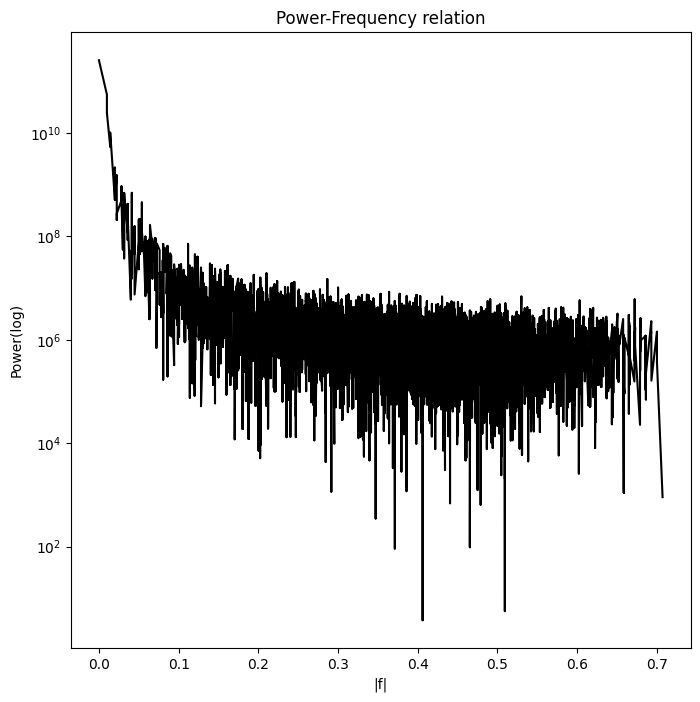

In [28]:
plt.figure(figsize=(8, 8))
plt.yscale("log")
plt.ylabel("Power(log)")
plt.xlabel("|f|")
plt.plot(pow_freq[0], pow_freq[1], color="black")
plt.title("Power-Frequency relation")
plt.show()

In [81]:
img3_fft_term = np.copy(img3_fft)
img3_fft_term[img3_freq > 1/5] = 0
count_freq = 0
lowest_freq_pow = max_pow
for i in range(100):
    for j in range(100):
        if img3_fft_term[i][j] != 0: count_freq += 1
        
print("# of data with freq > 1/5: " + str(count_freq))
img3_term = np.fft.ifft2(img3_fft_term)

# of data with freq > 1/5: 1257


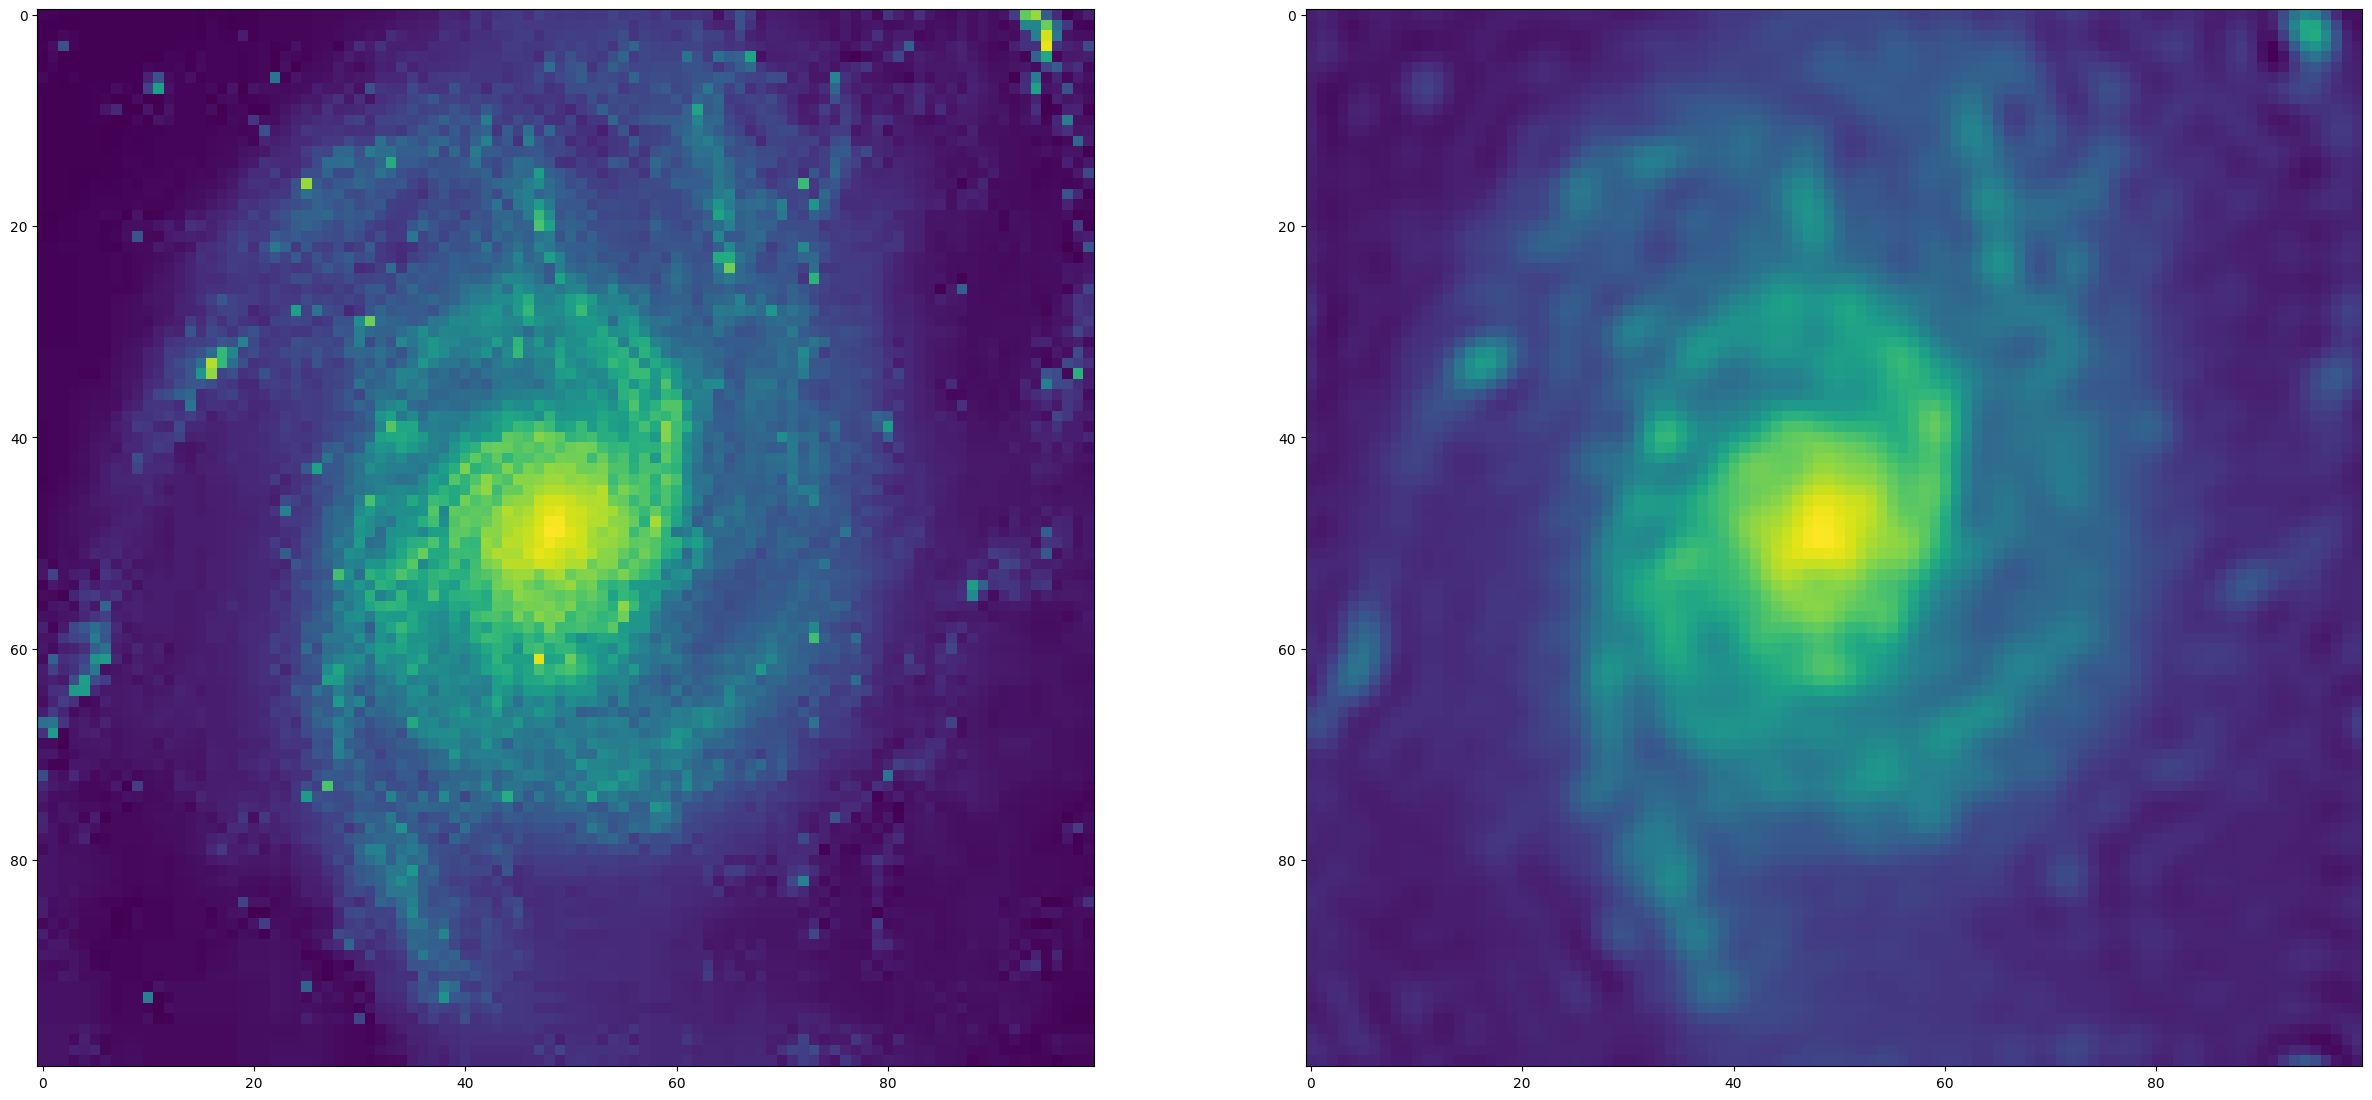

In [109]:
plt.figure(figsize=(30, 30))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(img3_term.real)

In [110]:
revised_img = image - img3_term.real


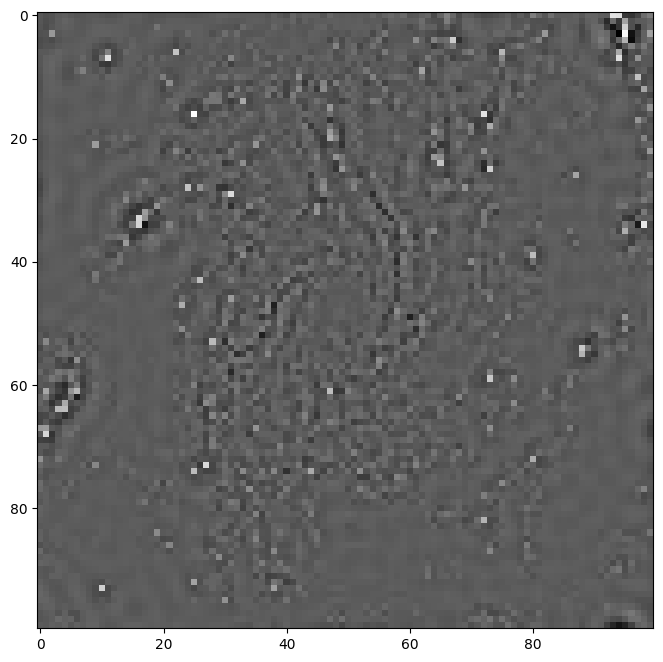

In [112]:
plt.figure(figsize=(8, 8))
plt.imshow(revised_img, cmap='gray')
plt.show()